<div style="float:left">
    <h1 style="width:600px">Technical assessment</h1>
    <h3 style="width:600px">Solution Engineer position</h3>
    <h3 style="width:600px">Author: Andres Restrepo</h3>

</div>
<div style="float: right; display: flex; align-items: center;">
    <img width="260" src="Logo/logo_CARTO_positive_180.png" />
</div>

## Libraries

In [1]:
#pip install rarfile

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import matplotlib.pyplot as plt

import zipfile
import rarfile
#import seaborn as sns

In [3]:
# # Setting theme
# sns.set_theme()

# Data

## Download

### Jaguar records

The jaguar records data is downloaded from the CARTO stack platform.

In [4]:
%%time
with zipfile.ZipFile('Data/Jag/carto-data.zip', 'r') as zip_file:
    with zip_file.open('puma_concolor.csv') as file:
        # read data as datafame
        raw_jag = pd.read_csv(file,low_memory=False)

CPU times: user 81.6 ms, sys: 20.4 ms, total: 102 ms
Wall time: 120 ms


In [5]:
# Raw data reading
raw_jag.head()

,issue,mediaType,license,dateIdentified,family,verbatimScientificNameAuthorship,institutionCode,genus,basisOfRecord,taxonKey,...,year,speciesKey,decimalLongitude,gbifID,order,datasetKey,geometry,stateProvince,longitude,latitude
0,COORDINATE_ROUNDED;INSTITUTION_MATCH_NONE;COLL...,NaN,CC_BY_NC_4_0,1970-01-01T00:00:00.000Z,Felidae,NaN,IIAP,Puma,HUMAN_OBSERVATION,2435099,...,2012,2435099,-76.686556,1503125323,Carnivora,5995e6ec-ec8e-4021-ab7b-37806367c48a,NaN,Chocó,-76.686556,5.133361
1,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2019,2435099,-73.409921,2556487738,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,NaN,Meta,-73.409921,3.551567
2,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2020,2435099,-73.409498,3332427318,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,NaN,Meta,-73.409498,3.526048
3,INSTITUTION_MATCH_NONE;COLLECTION_MATCH_NONE,NaN,CC_BY_NC_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",PROMIGAS S.A. E.S.P. (Promigas),Puma,HUMAN_OBSERVATION,2435099,...,2017,2435099,-75.189814,3019065673,Carnivora,8c145caa-8dca-40e6-b082-741e0d6b8f83,NaN,Atlántico,-75.189814,10.686383
4,GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_DERIVED_F...,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,NaN,NaN,Puma,PRESERVED_SPECIMEN,2435099,...,1996,2435099,-125.830000,2306925380,Carnivora,ad43e954-dd79-4986-ae34-9ccdbd8bf568,NaN,NaN,-125.830000,49.670000


In [6]:
# Data review
raw_jag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6790 entries, 0 to 6789
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   issue                             6232 non-null   object 
 1   mediaType                         2961 non-null   object 
 2   license                           6790 non-null   object 
 3   dateIdentified                    6790 non-null   object 
 4   family                            6790 non-null   object 
 5   verbatimScientificNameAuthorship  2225 non-null   object 
 6   institutionCode                   6754 non-null   object 
 7   genus                             6790 non-null   object 
 8   basisOfRecord                     6790 non-null   object 
 9   taxonKey                          6790 non-null   int64  
 10  month                             6790 non-null   int64  
 11  individualCount                   1526 non-null   float64
 12  day   

### Municipalties data

The municiplities data from Colombia is downloaded from the National Geostatistical Framework [(*Marco Geoestadistico Nacional*)](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/descarga-mgn-marco-geoestadistico-nacional/#gsc.tab=0) , published by the Colombian National Administrative and Statisticas Department [(*Departamento Administrativo Nacional de Estadistica*)](https://www.dane.gov.co/).

Colombian municipalites data: [Shapefile](https://geoportal.dane.gov.co/descargas/mgn_2021/MGN2021_MPIO_POLITICO.rar)

In [7]:
shapefile_path = 'Data/Mun/MGN_MPIO_POLITICO.shp'
geo_mun = gpd.read_file(shapefile_path)

In [8]:
# Raw data reading
geo_mun.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry
0,05,001,05001,ANTIOQUIA,MEDELLÍN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360..."
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05,004,05004,ANTIOQUIA,ABRIAQUÍ,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((-76.08351 6.75050, -76.08325 6.75048..."
3,05,021,05021,ANTIOQUIA,ALEJANDRÍA,Decreto departamental 304 de 1907,128.932153,4,2021,MUNICIPIO,0.705200,0.010535,"POLYGON ((-75.03320 6.41586, -75.03313 6.41585..."
4,05,030,05030,ANTIOQUIA,AMAGÁ,1912,84.132675,4,2021,MUNICIPIO,0.445241,0.006867,"POLYGON ((-75.67587 6.08561, -75.67540 6.08491..."


In [9]:
# Data review
geo_mun.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DPTO_CCDGO  1121 non-null   object  
 1   MPIO_CCDGO  1121 non-null   object  
 2   MPIO_CDPMP  1121 non-null   object  
 3   DPTO_CNMBR  1121 non-null   object  
 4   MPIO_CNMBR  1121 non-null   object  
 5   MPIO_CRSLC  1121 non-null   object  
 6   MPIO_NAREA  1121 non-null   float64 
 7   MPIO_CSMBL  1121 non-null   object  
 8   MPIO_VGNC   1121 non-null   int64   
 9   MPIO_TIPO   1121 non-null   object  
 10  Shape_Leng  1121 non-null   float64 
 11  Shape_Area  1121 non-null   float64 
 12  geometry    1121 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(8)
memory usage: 114.0+ KB


<AxesSubplot:>

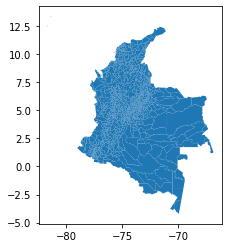

In [10]:
# Geometry
geo_mun.plot() 

In [11]:
# CRS
geo_mun.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Reading

### Jaguar records

In [12]:
# Set geometry
#geometry = gpd.points_from_xy(raw_jag['longitude'], raw_jag['latitude'])

In [13]:
# Reading geopandas df
geo_jag = gpd.GeoDataFrame(raw_jag, geometry=gpd.points_from_xy(raw_jag.longitude, raw_jag.latitude), crs="EPSG:4326")

In [14]:
# Data reading
geo_jag.head()

,issue,mediaType,license,dateIdentified,family,verbatimScientificNameAuthorship,institutionCode,genus,basisOfRecord,taxonKey,...,year,speciesKey,decimalLongitude,gbifID,order,datasetKey,geometry,stateProvince,longitude,latitude
0,COORDINATE_ROUNDED;INSTITUTION_MATCH_NONE;COLL...,NaN,CC_BY_NC_4_0,1970-01-01T00:00:00.000Z,Felidae,NaN,IIAP,Puma,HUMAN_OBSERVATION,2435099,...,2012,2435099,-76.686556,1503125323,Carnivora,5995e6ec-ec8e-4021-ab7b-37806367c48a,POINT (-76.68656 5.13336),Chocó,-76.686556,5.133361
1,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2019,2435099,-73.409921,2556487738,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,POINT (-73.40992 3.55157),Meta,-73.409921,3.551567
2,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2020,2435099,-73.409498,3332427318,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,POINT (-73.40950 3.52605),Meta,-73.409498,3.526048
3,INSTITUTION_MATCH_NONE;COLLECTION_MATCH_NONE,NaN,CC_BY_NC_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",PROMIGAS S.A. E.S.P. (Promigas),Puma,HUMAN_OBSERVATION,2435099,...,2017,2435099,-75.189814,3019065673,Carnivora,8c145caa-8dca-40e6-b082-741e0d6b8f83,POINT (-75.18981 10.68638),Atlántico,-75.189814,10.686383
4,GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_DERIVED_F...,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,NaN,NaN,Puma,PRESERVED_SPECIMEN,2435099,...,1996,2435099,-125.830000,2306925380,Carnivora,ad43e954-dd79-4986-ae34-9ccdbd8bf568,POINT (-125.83000 49.67000),NaN,-125.830000,49.670000


In [15]:
# Data review
geo_jag.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6790 entries, 0 to 6789
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   issue                             6232 non-null   object  
 1   mediaType                         2961 non-null   object  
 2   license                           6790 non-null   object  
 3   dateIdentified                    6790 non-null   object  
 4   family                            6790 non-null   object  
 5   verbatimScientificNameAuthorship  2225 non-null   object  
 6   institutionCode                   6754 non-null   object  
 7   genus                             6790 non-null   object  
 8   basisOfRecord                     6790 non-null   object  
 9   taxonKey                          6790 non-null   int64   
 10  month                             6790 non-null   int64   
 11  individualCount                   1526 non-null 

<AxesSubplot:>

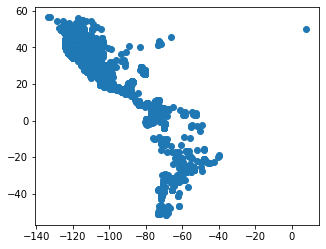

In [16]:
# Geometry
geo_jag.plot() 

In [17]:
# Setting CRS
geo_jag = geo_jag.to_crs(crs="EPSG:4686")

In [18]:
# Review new CRS
geo_jag.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Subsetting

### Spatial subsetting

In [19]:
geo_jag_col = gpd.clip(geo_jag, geo_mun)

In [20]:
geo_jag_col.shape

(544, 53)

In [21]:
geo_jag_col.head()

,issue,mediaType,license,dateIdentified,family,verbatimScientificNameAuthorship,institutionCode,genus,basisOfRecord,taxonKey,...,year,speciesKey,decimalLongitude,gbifID,order,datasetKey,geometry,stateProvince,longitude,latitude
461,PRESUMED_SWAPPED_COORDINATE;OCCURRENCE_STATUS_...,NaN,CC_BY_4_0,2016-10-11T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",CORMACARENA,Puma,HUMAN_OBSERVATION,2435099,...,2016,2435099,-73.793000,1804707606,Carnivora,bd87ead7-eb08-40ec-8ea3-1a61c134ec56,POINT (-73.79300 2.26100),Meta,-73.793000,2.261000
5959,NaN,NaN,CC_BY_NC_4_0,2019-08-25T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Asociación Colombiana de Zoología (ACZ),Puma,MACHINE_OBSERVATION,2435099,...,2019,2435099,-72.440560,3118575442,Carnivora,a9a819bb-b94e-4e06-bbbd-4cc1eb6f3b1c,POINT (-72.44056 -0.55063),Caquetá,-72.440560,-0.550630
743,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...,NaN,CC_BY_4_0,2011-01-01T00:00:00.000Z,Felidae,"Linnaeus, 1771",Cormacarena,Puma,HUMAN_OBSERVATION,2435099,...,2011,2435099,-72.903524,1978369815,Carnivora,0fca9cb2-caaa-499d-bf3d-8920c69a3a35,POINT (-72.90352 3.27006),Meta,-72.903524,3.270060
761,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...,NaN,CC_BY_4_0,2011-01-01T00:00:00.000Z,Felidae,"Linnaeus, 1771",Cormacarena,Puma,HUMAN_OBSERVATION,2435099,...,2011,2435099,-72.627905,1978369684,Carnivora,0fca9cb2-caaa-499d-bf3d-8920c69a3a35,POINT (-72.62790 3.36900),Meta,-72.627905,3.369002
764,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...,NaN,CC_BY_4_0,2011-01-01T00:00:00.000Z,Felidae,"Linnaeus, 1771",Cormacarena,Puma,HUMAN_OBSERVATION,2435099,...,2011,2435099,-72.511963,1978369755,Carnivora,0fca9cb2-caaa-499d-bf3d-8920c69a3a35,POINT (-72.51196 3.45241),Meta,-72.511963,3.452407


<AxesSubplot:>

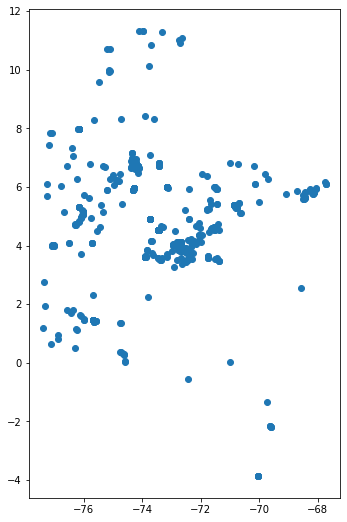

In [22]:
# Geometry
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_jag_col.plot(ax=ax) 

## Spatial aggregation

In [23]:
# Create a record count column
geo_mun['record_count'] = 0

In [24]:
# Count number of record in each municipality
for index, mun in geo_mun.iterrows():
    # Filter points that intersect with the current polygon
    intersecting_points = geo_jag_col[geo_jag_col.intersects(mun.geometry)]
    
    # Count the number of intersecting points
    count = len(intersecting_points)
    
    # Store the count in the 'point_count' column
    geo_mun.loc[index, 'record_count'] = count



In [25]:
geo_mun.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,record_count
0,05,001,05001,ANTIOQUIA,MEDELLÍN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360...",0
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571...",0
2,05,004,05004,ANTIOQUIA,ABRIAQUÍ,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((-76.08351 6.75050, -76.08325 6.75048...",0
3,05,021,05021,ANTIOQUIA,ALEJANDRÍA,Decreto departamental 304 de 1907,128.932153,4,2021,MUNICIPIO,0.705200,0.010535,"POLYGON ((-75.03320 6.41586, -75.03313 6.41585...",0
4,05,030,05030,ANTIOQUIA,AMAGÁ,1912,84.132675,4,2021,MUNICIPIO,0.445241,0.006867,"POLYGON ((-75.67587 6.08561, -75.67540 6.08491...",0


In [26]:
geo_mun.describe()

,MPIO_NAREA,MPIO_VGNC,Shape_Leng,Shape_Area,record_count
count,1121.000000,1121.0,1121.000000,1121.000000,1121.000000
mean,1017.816485,2021.0,1.482910,0.082813,0.485281
std,3219.209192,0.0,1.712757,0.260928,3.354901
min,15.828783,2021.0,0.173409,0.001292,0.000000
25%,132.755935,2021.0,0.615772,0.010835,0.000000
50%,287.807945,2021.0,0.970994,0.023515,0.000000
75%,704.098431,2021.0,1.656029,0.057297,0.000000
max,65597.250559,2021.0,20.045859,5.308583,71.000000


In [27]:
# Municipality with highest value of cases
geo_mun[geo_mun.record_count == geo_mun.record_count.max()]

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,record_count
703,50,573,50573,META,PUERTO LÓPEZ,Decreto 2543 de 1955,6913.346576,4,2021,MUNICIPIO,6.006052,0.562628,"POLYGON ((-72.15353 4.44037, -72.15195 4.44000...",71


<AxesSubplot:>

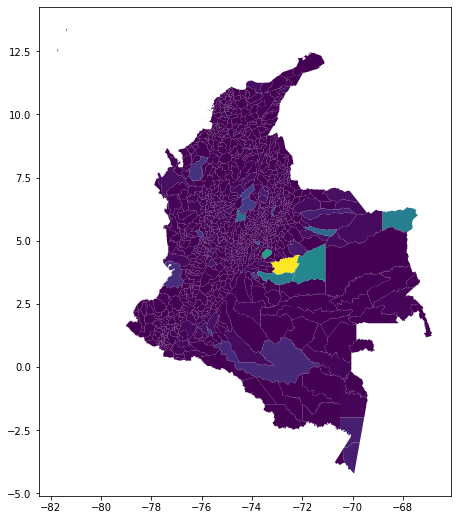

In [28]:
# Plotting by record count
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_mun.plot(column='record_count',ax=ax)